In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
%matplotlib inline
import csv 
import math
import bq
import time
import cPickle 
from matplotlib.patches import Polygon


In [2]:
client = bq.Client.Get()
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    #print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

cellsize = .1
one_over_cellsize = 10
if cellsize < 1:
    num_lons = 360*one_over_cellsize
    num_lats = 180 *one_over_cellsize
else:
    num_lons = 360/cellsize
    num_lats = 180/cellsize

numlons = num_lons
numlats = num_lats # because I used things incorrectly in later code

def get_area(lat):
    lat_degree = 69 # miles
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0        
    # phi = 90 - latitude
    phi = (lat+cellsize/2.)*degrees_to_radians #plus half a cell size to get the middle
    lon_degree = math.cos(phi)*lat_degree 
    # return 69*69*2.6
    return  lat_degree*lon_degree* 2.58999 # miles to square km

In [3]:
def make_raster(filename, vessel_days, output_name='', map_title = 'Density of Vessels with AIS'):

    plt.rcParams["figure.figsize"] = [12,7]

    cutoff = 0 # 5 degress away from the pole
    firstlat = 90-cutoff
    lastlat = -90+cutoff
    firstlon = -180
    lastlon = 180
    scale = cellsize

    vessel_days_truncated = vessel_days[one_over_cellsize*cutoff:(180*one_over_cellsize)-one_over_cellsize*cutoff][:]

    numlats = int((firstlat-lastlat)/scale+.5)
    numlons = int((lastlon-firstlon)/scale+.5)

    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

    fig = plt.figure()
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
    
#     m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
#               llcrnrlon=lastlon, urcrnrlon=firstlon, projection='mil',resolution="h", lon_0=0)

    m.drawmapboundary(fill_color='#111111')
    # m.drawcoastlines(linewidth=.2)
    # m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

    x = np.linspace(firstlon, lastlon, 360*one_over_cellsize)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar

    maximum = 100
    minimum = .0001

    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)

    m.pcolormesh(converted_x, converted_y, vessel_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))
    
    
    t = map_title
    plt.title(t, color = "#ffffff", fontsize=18)

    ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

    
    
    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        the_labels.append(l)

    #cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
    cb.set_label('Average Number of Vessels per 10,000 km$\mathregular{^2}$ in 2015',labelpad=-40, y=0.45, color = "#ffffff")

    ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='#ffffff', fontsize=6)

    plt.savefig(filename+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
    plt.show()

In [5]:
vessel_query = []

thedate = "20160101"

yyyy = thedate[:4]
mm = thedate[4:6]
dd = thedate[6:8]

for i in range(4):
    q = '''
SELECT
  INTEGER(FLOOR(lat*10)) lat_bin,
  INTEGER(FLOOR(lon*10)) lon_bin,
  SUM(IF(last_timestamp IS NOT NULL, (timestamp-last_timestamp)/3600000000, 
    (timestamp - TIMESTAMP("'''+yyyy+'-'+mm+"-"+dd+''' 00:00:00"))/3600000000)/2 + 
IF(next_timestamp IS NOT NULL, (next_timestamp - timestamp)/3600000000, 
  (TIMESTAMP("'''+yyyy+'-'+mm+"-"+dd+''' 23:59:59") - timestamp)/3600000000 )/2) hours
FROM
  [pipeline_classify_logistic_661b_bined.'''+thedate+''']
WHERE
  seg_id NOT IN (
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_661b.'''+thedate[:4]+'''_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
and lon > '''+ str(i*90-180) + ''' and lon < '''+ str(i*90-90)+'''
GROUP BY
  lat_bin,
  lon_bin'''
 

    vessel_query+= Query(q)
    

Waiting on bqjob_r16a6c08986d19129_00000155a1d39a7a_1 ... (3s) Current status: DONE   
Waiting on bqjob_r19b79abc6f163fea_00000155a1d3b8d8_2 ... (5s) Current status: DONE   
Waiting on bqjob_r17c74df1d9ac73ce_00000155a1d3e5fd_3 ... (5s) Current status: DONE   
Waiting on bqjob_r4dc6a0a7e6db8e8d_00000155a1d41291_4 ... (4s) Current status: DONE   


In [7]:
vessel_hours = np.zeros(shape=(num_lats,num_lons))

for row in vessel_query_filtered5:
    lat = int(row[0])
    lon = int(row[1])
    if lat<90*one_over_cellsize and lat>-90*one_over_cellsize and lon>-180*one_over_cellsize and lon<180*one_over_cellsize:
        lat_index = lat+90*one_over_cellsize
        lon_index = lon+180*one_over_cellsize
        hours = float(row[2])
        vessel_hours[lat_index][lon_index] = hours
#         area = get_area(lat*float(cellsize)) # approximate area of 1 by 1 degree at a given lat
#         vessel_days[lat_index][lon_index] = days / (24*365.* area*cellsize*cellsize)*10000 #vessels per day per 10,000 square km
         

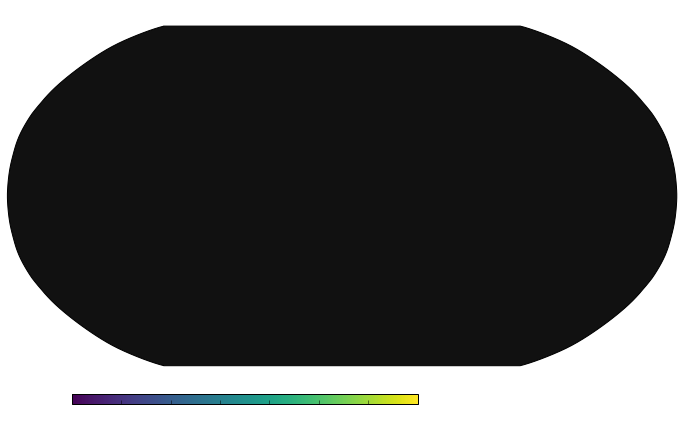

In [9]:
make_raster(thedate, vessel_hours, output_name='', map_title = 'Density of Vessels with AIS')